Le but de ce TP est de réaliser une classification supervisées des images du TP précédent. 4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


<font color="orange">Préparer la cellule des imports (on commence à en avoir l'habitude !).</font>

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from plot_keras_history import show_history, plot_history
import seaborn as sns
from skimage import io
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


<font color="orange">Charger les fichiers pickle utilisés dans le TP précédent pour sérialiser nos variables utiles. Vérifier que les variables contiennent bien ce qu'on attend.</font>

In [2]:
with open("features_array.pkl", "rb") as handle:
    feat_pca_array = pkl.load(handle)
with open("img_df.pkl", "rb") as handle:
    img_df = pkl.load(handle)
print(feat_pca_array)
display(img_df.head())

[[ 1.9544766e+00 -1.4717954e+01 -5.3037477e+00 ... -7.2532974e-02
  -5.0635785e-01 -2.6224542e-01]
 [ 6.2963510e-01 -1.2585759e+01 -2.3373365e-01 ...  6.8578728e-02
   3.5400692e-01  1.1424346e-01]
 [-3.5353053e+00 -9.5045137e+00  1.0362120e+01 ... -2.8378537e-01
  -3.3193159e-01  2.7808327e-02]
 ...
 [ 3.2934761e+01  2.1253059e+01 -1.2920221e+01 ... -2.9714820e-01
  -2.1840538e-01 -4.5804556e-02]
 [ 3.4682747e+01  1.9640528e+01 -3.1260743e+00 ...  2.0042632e-03
   1.2696417e-01  1.4020243e-01]
 [ 2.1140398e+01  2.8663256e+00 -1.1699773e+01 ... -2.1752882e-01
   2.4104546e-01 -1.0651556e-01]]


,image_path,label_name,label
0,.\dataset\cloudy1.jpg,cloudy,0
1,.\dataset\cloudy10.jpg,cloudy,0
2,.\dataset\cloudy100.jpg,cloudy,0
3,.\dataset\cloudy101.jpg,cloudy,0
4,.\dataset\cloudy102.jpg,cloudy,0


<font color="orange">Redéclarer la liste des labels (dans l'ordre d'encodage avec le champ label).</font>

In [41]:
LABELS_LIST = ["cloudy", "rain", "shine", "sunrise"]

### Préparation des images

<font color="orange">En sélectionnant une image aléatoire du dataset, écrire le traitement que suivra cette image, en suivant les étapes suivantes :
- charger l'image avec la fonction load_img du module tensorflow.keras.preprocessing.image, en utilisant l'argument target_size pour forcer une redimension fixée à 224x224,
- convertir l'image en array avec la fonction img_to_array de ce même module,
- appliquer la fonction de préprocessing déjà prête de VGG16 : preprocess_input du module tensorflow.keras.applications.vgg16.

Ajouter une visualisation après l'étape 1 (pour se convaincre qu'on a bien chargé l'image initiale) ainsi qu'après l'étape 3 (pour visualiser que le préprocessing VGG16 déjà implémenté change significativement l'image, qui ne sera déjà plus vraiment interprétable à l'oeil).</font> Attention, petit rappel, après l'étape 1 l'objet est une image tandis qu'après la dernière étape il s'agit d'un array : les fonctions pour afficher ces deux objets ne sont donc pas tout à fait les mêmes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


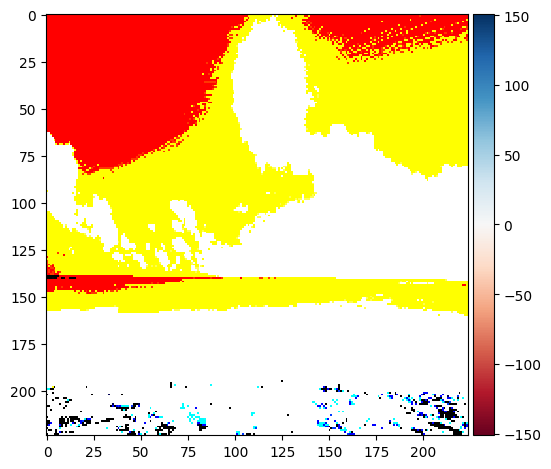

In [5]:
img = load_img(
    img_df['image_path'][765],
    target_size=(224, 224),
)
img.show()
img = img_to_array(img)
img = preprocess_input(img)
io.imshow(img)
io.show()

<font color="orange">A partir du traitement unitaire écrit précédemment, écrire la fonction prenant en entrée notre dataframe et créant le tableau de toutes les images contenues dans le dataframe (dans l'ordre).</font> Utiliser une simple boucle for pour créer une liste de représentations array d'images (ne pas réfléchir spécialement à des opérations vectorielles, le chargement même des images n'est pas vectorisable), puis convertir cette liste elle-même en tableau numpy grâce à np.array. Ne pas oublier d'enlever les visualisations, qui ne feraient que nous polluer désormais lorsque la fonction sera appelée sur le dataset entier de plus de 1000 images.

In [6]:
def prepare_images(img_df: pd.DataFrame) -> np.ndarray:
    prepared_images = []
    for image_num in range(len(img_df['image_path'])):
        img = (load_img(
            img_df['image_path'][image_num],
            target_size=(224, 224),
        ))
        img = img_to_array(img)
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

<font color="orange">Appeler cette fonction sur notre dataframe d'images.</font> Ce traitement prendra plusieurs minutes.

In [7]:
X = prepare_images(img_df=img_df)

<font color="orange">Préparer le vecteur y en appelant to_categorical sur la colonne contenant le label (numérique).</font>

In [11]:
y = to_categorical(img_df['label'])

<font color="orange">Séparer le jeu de données en un jeu d'entraînement et un jeu de test. Fixer un random_state pour garantir la reproductibilité des résultats pendant la phase d'élaboration de notre modèle. Stratifier selon la cible.</font>

In [16]:
X_macro_train, X_test, y_macro_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

Remarque : généralement cette étape est effectuée AVANT tout autre traitement afin d'éviter tout data leakage. Pour autant, ici, la fonction de préprocessing s'applique aux images de façon unitaire (le traitement d'un image n'est pas dépendant des autres images), et, étant donné la stratification, toutes les classes du référentiel seront nécessairement représentées dans le jeu d'entraînement et dans celui de test, de sorte que l'encoding de la cible dans le jeu de test ne révèlera pas de surprise de type modalité inconnue.

<font color="orange">Redécouper le jeu d'entraînement en mini-jeu d'entraînement et jeu de validation.</font>

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_macro_train, y_macro_train, stratify=y_macro_train, test_size=0.2, random_state=0)

In [18]:
X_train.shape

(720, 224, 224, 3)

### Préparation du modèle

<font color="orange">Ecrire une fonction permettant de créer notre modèle VGG16.</font> Pour cela :
- instancier un objet VGG16. A partir de la doc, faire en sorte d'initialiser les points à ceux du modèle pré-entraîné sur le jeu ImageNet. Choisir par exemple de ne pas inclure les 3 premières couches fully-connected, et spécifier dans ce cas une taille d'entrée de 224x224x3
- indiquer que toutes ces couches seront "gelées" (non entraînables). Pour cela, boucler sur l'ensemble des éléments de model.layers et définir l'attribut trainable à False.
- stocker dans une variable model.output, puis ajouter une couche de pooling, une couche dense, une couche de dropout et une dernière couche dense.
- définir le nouveau modèle et le compiler.

In [19]:
def create_model():
    """Create a model from the VGG16 model, adding a task head for image
    classification.
    """
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

<font color="orange">Créer effectivement le modèle, avec un context manager spécifiant le device à utiliser (c'est ici qu'on spécifierait quel GPU utiliser si on en disposer). Dans notre cas, utilisons "/cpu:0"</font>

In [ ]:
with tf.device("/cpu:0"): 
    model1 = create_model()

<font color="orange">Créer un "callback" pour créer un early stopping de la manière suivante et sauvegarder le modèle de la manière suivante :</font>

In [20]:
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<font color="orange">A l'intérieur du context manager spécifiant le device à utiliser, lancer l'entraînement du modèle. Prévoir dès maintenant de sauvegarder la sortie dans une variable appelée history (nous l'utiliserons plus tard). Attention à bien préciser le jeu de validation ! </font>

In [23]:
with tf.device('/cpu:0'): 
    history1 = model1.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=64,
        callbacks=callbacks_list,
        validation_data=(X_val, y_val),
        verbose=1,
    )


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.9056
Epoch 1: val_loss improved from 0.27297 to 0.17064, saving model to .\model1_best_weights.h5
12/12 [==============================] - 138s 12s/step - loss: 0.3165 - accuracy: 0.9056 - val_loss: 0.1706 - val_accuracy: 0.9333
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9292
Epoch 2: val_loss did not improve from 0.17064
12/12 [==============================] - 136s 11s/step - loss: 0.1991 - accuracy: 0.9292 - val_loss: 0.1948 - val_accuracy: 0.9389
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9347
Epoch 3: val_loss did not improve from 0.17064
12/12 [==============================] - 139s 12s/step - loss: 0.1783 - accuracy: 0.9347 - val_loss: 0.1722 - val_accuracy: 0.9222
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.9486
Epoch 4: val_loss did not improve from 0.170

<font color="orange">Vérifier le score du dernier epoch sur le jeu d'entraînement et le jeu de validation grâce à la méthode evaluate de notre modèle entraîné.</font>

In [24]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy: {:.4f}".format(accuracy))

23/23 [==============================] - 113s 5s/step - loss: 0.0227 - accuracy: 0.9958
Training Accuracy: 0.9958

6/6 [==============================] - 29s 5s/step - loss: 0.1778 - accuracy: 0.9333
Validation Accuracy:  0.9333


<font color="orange">Vérifier le score de l'epoch optimal sur le jeu de validation et le jeu de test.</font>

In [25]:
model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.9333
Test Accuracy       :  0.9111


<font color="orange">Consulter la doc de plot_keras_history. A partir de celle-ci, visualiser l'évolution de la loss et de l'accuracy au fil des epochs.</font>

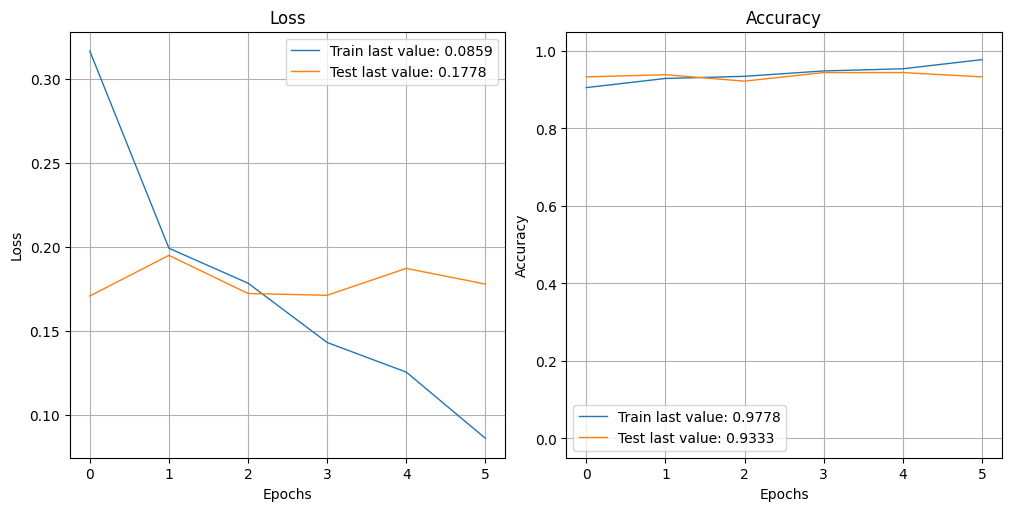

In [30]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

<font color="orange">Afficher les classes réelles et prédites sur les images du jeu de validation.</font>

In [31]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)

print(y_val_num)
print(y_val_pred)

6/6 [==============================] - 23s 4s/step
[2 0 3 2 2 0 2 2 0 0 0 2 0 2 2 3 3 3 2 1 2 3 0 2 1 3 0 0 3 0 2 2 2 1 3 0 1
 1 0 0 1 3 2 0 3 3 1 1 0 3 2 3 3 0 1 0 2 3 1 0 0 3 3 3 1 3 3 0 3 1 3 1 2 2
 0 2 3 2 1 0 1 2 0 3 2 1 1 2 2 0 1 1 1 0 3 0 3 0 3 2 3 0 3 0 3 1 0 2 3 3 0
 2 3 0 3 3 0 2 3 3 1 1 1 2 3 3 0 0 3 3 0 1 3 0 2 2 3 2 1 2 1 1 3 0 3 0 0 0
 3 2 3 3 3 1 0 1 0 1 3 1 1 0 3 3 2 0 0 3 0 2 3 3 2 1 2 2 0 3 3 2]
[0 0 3 2 2 2 2 2 0 0 0 2 0 2 2 3 3 3 2 1 0 3 0 2 1 3 0 0 3 0 2 3 2 1 3 0 1
 1 0 0 1 3 2 0 3 3 2 1 0 3 2 3 3 0 1 0 2 3 1 0 3 3 3 3 1 3 3 0 3 1 3 1 2 2
 0 2 3 3 1 3 1 2 0 3 2 1 1 2 2 3 3 1 1 0 3 0 3 0 3 2 3 0 3 0 3 1 0 2 3 3 0
 2 3 0 3 3 0 2 3 3 1 1 1 2 3 3 0 0 3 3 0 1 2 0 2 2 3 2 1 3 1 1 3 0 3 0 0 0
 3 2 3 3 3 1 0 1 0 1 3 1 1 0 3 3 2 0 0 3 0 2 3 3 2 1 2 2 0 3 3 2]


<font color="orange">De manière analogue au TP précédent, afficher la matrice de confusion associée ainsi que le rapport de classification.</font>

In [37]:
conf_mat = metrics.confusion_matrix(
    y_true=y_val_num,
    y_pred=y_val_pred,
)
print(conf_mat)

[[44  0  1  3]
 [ 0 32  1  1]
 [ 2  0 36  3]
 [ 0  0  1 56]]


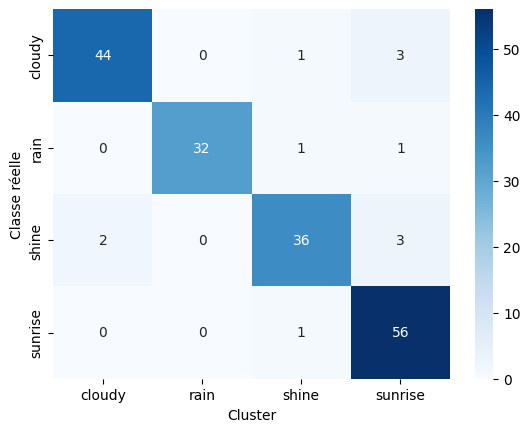

In [42]:
sns.heatmap(
    data=conf_mat,
    annot=True,
    cmap="Blues",
    fmt="g",
    xticklabels=LABELS_LIST,
    yticklabels=LABELS_LIST,
)
plt.xlabel("Cluster")
plt.ylabel("Classe réelle")
plt.show()

In [44]:
print(metrics.classification_report(y_val_num, y_val_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        48
           1       1.00      0.94      0.97        34
           2       0.92      0.88      0.90        41
           3       0.89      0.98      0.93        57

    accuracy                           0.93       180
   macro avg       0.94      0.93      0.93       180
weighted avg       0.94      0.93      0.93       180



<font color="orange">Essayer éventuellement de visualiser les prédictions sur les images de test et en particulier, s'il y en a, sur des images présentant des écueils soulevés dans le TP précédent (par exemple des images avec de la neige).</font>

### Data augmentation (intégrée au modèle)

Une ressource utile est celle de tensorflow sur la data augmentation, située à l'adresse suivante : https://www.tensorflow.org/tutorials/images/data_augmentation

Grâce au tutorial (première méthode), créer une data augmentation contenant RandomFlip, RandomRotation et RandomZoom.

In [48]:
def create_model_with_data_augmentation() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(4, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [52]:
# Création du modèle
with tf.device('/cpu:0'): 
    model4 = create_model_with_data_augmentation()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [53]:
with tf.device('/cpu:0'): 
    history4 = model4.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=64,
        callbacks=callbacks_list,
        validation_data=(X_val, y_val),
        verbose=1,
    )

Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 1.3376 - accuracy: 0.3944 
Epoch 1: val_loss improved from inf to 1.03055, saving model to .\model4_best_weights.h5


c:\Users\bspeziale\AppData\Local\pypoetry\Cache\virtualenvs\test-yOZBwoax-py3.11\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 178s 15s/step - loss: 1.3376 - accuracy: 0.3944 - val_loss: 1.0306 - val_accuracy: 0.7389
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.9756 - accuracy: 0.6014 
Epoch 2: val_loss improved from 1.03055 to 0.81562, saving model to .\model4_best_weights.h5
12/12 [==============================] - 160s 14s/step - loss: 0.9756 - accuracy: 0.6014 - val_loss: 0.8156 - val_accuracy: 0.7556
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.7476 - accuracy: 0.7569 
Epoch 3: val_loss improved from 0.81562 to 0.68578, saving model to .\model4_best_weights.h5
12/12 [==============================] - 174s 15s/step - loss: 0.7476 - accuracy: 0.7569 - val_loss: 0.6858 - val_accuracy: 0.7722
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.6377 - accuracy: 0.7903 
Epoch 4: val_loss improved from 0.68578 to 0.58405, saving model to .\model4_best_weights.h5
12/12 [==============================] - 16

<font color="orange">Reprendre l'ensemble des questions précédentes et comparer les deux modèles.</font>